<a href="https://colab.research.google.com/github/rajdeepbanerjee-git/JNCLectures_Intro_to_ML/blob/main/Week9/Lec9_bagging_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


In [74]:
data = pd.read_csv("Hitters.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [75]:
data.drop(["League","Division","NewLeague"], axis = 1, inplace = True)
data.dropna(how = "any", inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AtBat    263 non-null    int64  
 1   Hits     263 non-null    int64  
 2   HmRun    263 non-null    int64  
 3   Runs     263 non-null    int64  
 4   RBI      263 non-null    int64  
 5   Walks    263 non-null    int64  
 6   Years    263 non-null    int64  
 7   CAtBat   263 non-null    int64  
 8   CHits    263 non-null    int64  
 9   CHmRun   263 non-null    int64  
 10  CRuns    263 non-null    int64  
 11  CRBI     263 non-null    int64  
 12  CWalks   263 non-null    int64  
 13  PutOuts  263 non-null    int64  
 14  Assists  263 non-null    int64  
 15  Errors   263 non-null    int64  
 16  Salary   263 non-null    float64
dtypes: float64(1), int64(16)
memory usage: 37.0 KB


In [76]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Baseline regressor

In [77]:
# fit basic regression tree with depth 1
base_tree = DecisionTreeRegressor(max_depth=1, random_state=0)
base_tree.fit(X_train, y_train)
y_pred = base_tree.predict(X_test)

# metrics
r2_score(y_test, y_pred)

0.22707377995666833

In [78]:
# create bootstrapped samples
# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(42)

def get_bootstrap_data(X_train, y_train):

    train_indices = X_train.index
    bootstrap_indices = rng.choice(train_indices,
                                  len(train_indices),
                                  replace = True)
    ratio = len(set(train_indices).intersection(set(bootstrap_indices)))/len(train_indices)
    X_train_bootstrap = X_train.loc[bootstrap_indices]
    y_train_bootstrap = y_train.loc[bootstrap_indices]

    return X_train_bootstrap, y_train_bootstrap, ratio

In [86]:
# Now, we take four trees and train on separate bootrapped samples.
# Final prediction is the average of all the 4 predictions for each test observation
n_tree = 500
y_pred = []
tree = DecisionTreeRegressor(max_depth=1, random_state=0)

for i in range(n_tree):
  X_train_bootstrap, y_train_bootstrap, _ = get_bootstrap_data(X_train = X_train, y_train = y_train)
  tree.fit(X_train_bootstrap, y_train_bootstrap)
  y_pred_bootstrap = tree.predict(X_test)
  y_pred.append(y_pred_bootstrap)

In [90]:
# final prediction is average of bootstrapped tree predicitons
y_pred_final = np.mean(np.stack(np.array(y_pred).T, axis = 0), axis = 1)

# metrics
r2_score(y_test, y_pred_final)

0.272207333086399

We have increased accuracy from 20% to 25% by bootstrapped aggregation. <br>
Note: The reason why we have taken depth = 1 is that we can use the concept of random forest at the first split without going into bigger trees (which, writing from scratch would mean inheriting the DecisionTreeRegressor class and overwriting the methods). Obviousely our score will be low as tree depth is 1 (high bias!) - but it will convey the idea, trust me!


In [81]:
# In random forest, each tree built on the bootstrap sample will have m features
# randomly chosen from p features. This should be repeated for each node while growing the
# tree, but since we have only one node, the following will suffice!
# Note, selecting m features and getting best split is same as passing a filtered data to the depth = 1 decision tree

def get_bootstrap_rf_data(X_train, y_train, n_features):

    train_indices = X_train.index
    bootstrap_indices = rng.choice(train_indices,
                                  len(train_indices),
                                  replace = True)
    feature_indices = list(rng.choice(range(X_train.shape[1]), n_features))

    X_train_bootstrap = X_train.loc[bootstrap_indices]
    y_train_bootstrap = y_train.loc[bootstrap_indices]

    X_train_bootstrap_rf = X_train_bootstrap.iloc[:, feature_indices]

    return X_train_bootstrap_rf, y_train_bootstrap, feature_indices

In [92]:
n_tree = 500
y_pred = []
tree = DecisionTreeRegressor(max_depth=1, random_state=0)

for i in range(n_tree):
  X_train_bootstrap, y_train_bootstrap, feature_indices = get_bootstrap_rf_data(X_train = X_train,
                                                              y_train = y_train,
                                                              n_features = 4)
  tree.fit(X_train_bootstrap, y_train_bootstrap)
  y_pred_bootstrap = tree.predict(X_test.iloc[:, feature_indices])
  y_pred.append(y_pred_bootstrap)

In [97]:
# final prediction is average of bootstrapped tree predicitons
y_pred_final = np.mean(np.stack(np.array(y_pred).T, axis = 0), axis = 1)

# metrics
r2_score(y_test, y_pred_final)

0.26588830460749935

Question: Plot the test r2 score for the bagging and rf case as a function of n_tree.
1. Can you explain what you see?
2. Run it multiple times and plot, how does the plot change? Why?

In [93]:
kwargs = {"n_tree": 10,
          "X_train": X_train,
          "y_train": y_train,
          "X_test": X_test,
          "y_test": y_test}

In [95]:
def get_bagging_results(n_tree, X_train, y_train, X_test, y_test):

  y_pred = []
  tree = DecisionTreeRegressor(max_depth=1, random_state=0)

  for i in range(n_tree):
    X_train_bootstrap, y_train_bootstrap, _ = get_bootstrap_data(X_train = X_train, y_train = y_train)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_bootstrap = tree.predict(X_test)
    y_pred.append(y_pred_bootstrap)

  # final prediction is average of bootstrapped tree predicitons
  y_pred_final = np.mean(np.stack(np.array(y_pred).T, axis = 0), axis = 1)

  return r2_score(y_test, y_pred_final)

In [105]:
get_bagging_results(**kwargs)

0.25800060265181857

In [98]:
def get_rf_results(n_tree, X_train, y_train, X_test, y_test):

  y_pred = []
  tree = DecisionTreeRegressor(max_depth=1, random_state=0)

  for i in range(n_tree):
    X_train_bootstrap, y_train_bootstrap, feature_indices = get_bootstrap_rf_data(X_train = X_train,
                                                                                  y_train = y_train,
                                                                                  n_features = 4)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_bootstrap = tree.predict(X_test.iloc[:, feature_indices])
    y_pred.append(y_pred_bootstrap)

  # final prediction is average of bootstrapped tree predicitons
  y_pred_final = np.mean(np.stack(np.array(y_pred).T, axis = 0), axis = 1)


  return r2_score(y_test, y_pred_final)

In [106]:
get_rf_results(**kwargs)

0.2695552047687416

In [110]:
bagging_results = []
rf_results = []
for n in np.arange(10, 500, 50):
  kwargs["n_tree"] = n
  bagging_results.append(get_bagging_results(**kwargs))
  rf_results.append(get_rf_results(**kwargs))

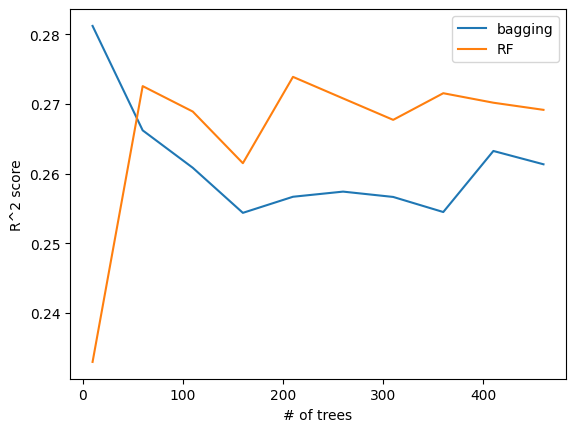

In [114]:
# plot
plt.plot(np.arange(10, 500, 50), bagging_results, label = "bagging")
plt.plot(np.arange(10, 500, 50), rf_results, label = "RF")
plt.legend()
plt.xlabel("# of trees")
plt.ylabel("R^2 score")
plt.show()